In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import json

In [162]:
# For testing of code, remove this afterwards, and add in the line to receive the processed data
#train_data = pd.read_csv('train.csv')
train_data = pd.read_csv('train_oversampled.csv')
test_data = pd.read_csv('test.csv')

In [164]:
print("Total =", len(train_data), '\n')
AR = train_data[(train_data['PrevLifecycle_Reactivated'] == 1) | (train_data['PrevLifecycle_Active'] == 1)]

print("Churned =", len(train_data[train_data['CurrLifecycle_Churned'] == 1]))
print("Not churn =", len(train_data[train_data['CurrLifecycle_Churned'] == 0]))
print("Churn percentage =", (len(train_data[train_data['CurrLifecycle_Churned'] == 1])/len(train_data))*100, '\n')

print("Active =", len(train_data[train_data['CurrLifecycle_Active'] == 1]))
print("Not active =", len(train_data[train_data['CurrLifecycle_Active'] == 0]))
print("Active percentage =", (len(train_data[train_data['CurrLifecycle_Active'] == 1])/len(train_data))*100, '\n')

#print("Dormant from A/R =", len(AR[AR['CurrLifecycle_Dormant'] == 1]))
#print("Not Dormant from A/R =", len(AR[AR['CurrLifecycle_Dormant'] == 0]))

print("Reactivated =", len(train_data[train_data['CurrLifecycle_Reactivated'] == 1]))
print("Not Reactivated =", len(train_data[train_data['CurrLifecycle_Reactivated'] == 0]))
print("Reactivated percentage =", (len(train_data[train_data['CurrLifecycle_Reactivated'] == 1])/len(train_data))*100, '\n')

print("Dormant =", len(train_data[train_data['CurrLifecycle_Dormant'] == 1]))
print("Not Dormant =", len(train_data[train_data['CurrLifecycle_Dormant'] == 0]))
print("Dormant percentage =", (len(train_data[train_data['CurrLifecycle_Dormant'] == 1])/len(train_data))*100, '\n')

Total = 236117 

Churned = 132027
Not churn = 104090
Churn percentage = 55.915923038154816 

Active = 71959
Not active = 164158
Active percentage = 30.475992834061078 

Reactivated = 32020
Not Reactivated = 204097
Reactivated percentage = 13.5610735355777 

Dormant = 111
Not Dormant = 236006
Dormant percentage = 0.047010592206406146 



### Old Data Processing

In [ ]:
cols = raw_train.columns
X = raw_train[cols[3:-1]].drop(columns=['Gender', 'Geography'])
y = raw_train[
[cols[-1]]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## CODE TO PREPROCESS THE DATASET

cols = raw_train.columns
#X = raw_train.iloc[:,3:].drop(columns=['Gender', 'Geography'])
X = raw_train.drop(columns=['Gender', 'ChurnDate', 'FirstPersona', 'SecondPersona', 'ThirdPersona', 'CombinedPersonas', 'SocialInfluencer'])
X['Active'] = (X['CurrLifecycle'] == 'Active').astype(int)
X['Reactivated'] = (X['CurrLifecycle'] == 'Reactivated').astype(int)
X['Dormant'] = (X['CurrLifecycle'] == 'Dormant').astype(int)
X['Churned'] = (X['CurrLifecycle'] == 'Churned').astype(int)

strat = raw_train['CurrLifecycle']
all_train, all_test, strat_train, strat_test = train_test_split(X, strat, test_size=0.2, random_state=42)

In [ ]:
#y_train_a, y_train_r, y_train_d, y_train_c = all_train['Active'], all_train['Reactivated'], all_train['Dormant'], all_train['Churned']
#y_test_a, y_test_r, y_test_d, y_test_c = all_test['Active'], all_test['Reactivated'], all_test['Dormant'], all_test['Churned']

y_train_all = [all_train['Active'], all_train['Reactivated'], all_train['Dormant'], all_train['Churned']]
y_test_all = [all_test['Active'], all_test['Reactivated'], all_test['Dormant'], all_test['Churned']]
X_train = all_train.drop(columns=['Active', 'Reactivated', 'Dormant', 'Churned'])
X_test = all_test.drop(columns=['Active', 'Reactivated', 'Dormant', 'Churned'])

In [ ]:
## WONT USE THIS
y_train_a, y_train_r, y_train_d, y_train_c = y_train, y_train, y_train, y_train
y_test_a, y_test_r, y_test_d, y_test_c = y_test, y_test, y_test, y_test

y_train_all = [y_train_a, y_train_r, y_train_d, y_train_c]
y_test_all = [y_test_a, y_test_r, y_test_d, y_test_c]

### New data processing

In [165]:
features_dropped = ['CustomerID', 'Gender', 'ChurnDate', 'FirstPersona', 'SecondPersona', 'ThirdPersona', 'CombinedPersonas', 
                   'CurrLifecycle', 'SocialInfluencer', 
                   'CurrLifecycle_Active', 'CurrLifecycle_Reactivated', 'CurrLifecycle_Churned', 'CurrLifecycle_Dormant', 
                   'PrevLifecycle_Active', 'PrevLifecycle_Churned', 'PrevLifecycle_Dormant', 'PrevLifecycle_Reactivated',
                   'PrevLifecycle', 'CustomerId']

input_features = [column for column in train_data.columns if column not in features_dropped]

In [166]:
train_data['MonthsInactive'] = train_data['MonthsInactive'].fillna(0)
test_data['MonthsInactive'] = test_data['MonthsInactive'].fillna(0)

In [167]:
# Encode categorical variables for logistic regression
label_encoder = LabelEncoder()
train_data_encoded = train_data.copy()
test_data_encoded = test_data.copy()

for column in train_data_encoded.columns:
    if train_data_encoded[column].dtype == 'object':
        train_data_encoded[column] = label_encoder.fit_transform(train_data_encoded[column])
        test_data_encoded[column] = label_encoder.fit_transform(test_data_encoded[column])

In [168]:
# Copy data sets to do encoding and scaling for logistic regression
train_lgr = train_data_encoded.copy()
test_lgr = test_data_encoded.copy()

In [169]:
# Scale dataset (except for the labels) for logistic regression
scaler = StandardScaler()

label_columns = ['CurrLifecycle_Active', 'CurrLifecycle_Reactivated', 'CurrLifecycle_Dormant', 'CurrLifecycle_Churned']
feature_columns = [column for column in train_lgr.columns if column not in label_columns]

train_lgr_features = train_lgr[feature_columns]
train_lgr_labels = train_lgr[label_columns]

train_lgr_features = pd.DataFrame(scaler.fit_transform(train_lgr_features), columns = train_lgr_features.columns)
train_lgr = pd.concat([train_lgr_features, train_lgr_labels], axis = 1)

test_lgr_features = test_lgr[feature_columns]
test_lgr_labels = test_lgr[label_columns]

test_lgr_features = pd.DataFrame(scaler.transform(test_lgr_features), columns = test_lgr_features.columns)
test_lgr = pd.concat([test_lgr_features, test_lgr_labels], axis = 1)

In [170]:
y_train_all_lgr = [train_lgr['CurrLifecycle_Active'], train_lgr['CurrLifecycle_Reactivated'], train_lgr['CurrLifecycle_Dormant'], train_lgr['CurrLifecycle_Churned']]
y_test_all_lgr = [test_lgr['CurrLifecycle_Active'], test_lgr['CurrLifecycle_Reactivated'], test_lgr['CurrLifecycle_Dormant'], test_lgr['CurrLifecycle_Churned']]

y_train_all = [train_data_encoded['CurrLifecycle_Active'], train_data_encoded['CurrLifecycle_Reactivated'], train_data_encoded['CurrLifecycle_Dormant'], train_data_encoded['CurrLifecycle_Churned']]
y_test_all = [test_data_encoded['CurrLifecycle_Active'], test_data_encoded['CurrLifecycle_Reactivated'], test_data_encoded['CurrLifecycle_Dormant'], test_data_encoded['CurrLifecycle_Churned']]

## Logistic Regression

In [11]:
#Code to ignore the DataConversionWarning
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [12]:
lr_model = LogisticRegression()

In [13]:
# Hyperparameter Tuning
lr_param_dist = {
    'penalty': ['l1', 'l2'],  
    #'C' : np.logspace(-4, 4, 20),
    'C': [0.1, 1, 10, 100, 1000],  
    'solver': ['liblinear', 'saga'] 
}


In [ ]:
train_data_encoded[input_features].head()

In [14]:
lr_models = []
lr_results = []

for i in range(4):
    lr_model = LogisticRegression()
    search_lr = RandomizedSearchCV(lr_model, param_distributions=lr_param_dist, n_iter=5, scoring='f1_weighted', cv=5, random_state=42)

    search_lr.fit(train_lgr[input_features], y_train_all_lgr[i])

    best_model_lr = search_lr.best_estimator_
    lr_models.append(best_model_lr)
    
    test_score_lr = best_model_lr.score(test_lgr[input_features], y_test_all_lgr[i])
    lr_results.append(test_score_lr)
    print("yeay done")

C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ di

yeay done


C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

yeay done


C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

yeay done


C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

yeay done


In [15]:
lr_results

[0.7301178537885903, 0.7590511103705274, 0.99957584754749, 0.9996061441512406]

### GB, might not use

In [ ]:
gb_model = GradientBoostingClassifier()

In [ ]:
# Hyperparameter Tuning
gb_param_dist = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': np.arange(0., 2., 0.2).tolist(),
    'n_estimators': np.arange(100, 301, 100).tolist(),
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_leaf': np.arange(6,15, 2).tolist(),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': np.arange(2,15, 2).tolist(),
    'max_depth': np.arange(3,16, 3).tolist()
}

#search = BayesSearchCV(
#    estimator=gb_model,
#    search_spaces=gb_param_dist,
#    n_iter=50,
#    cv=5
#)

search = RandomizedSearchCV(gb_model, param_distributions=gb_param_dist, n_iter=10, scoring='f1_weighted', cv=5, random_state=42)


# Perform optimization
search.fit(X_train, y_train)

print("Best parameters found: ", search.best_params_)

# Evaluate the best model on the test set
best_model = search.best_estimator_
gb_predictions = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
print("Test score of the best model: ", test_score)


## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier()

In [16]:
# Define the XGBoost parameter ranges
xgb_param_dist = {
    'booster': ['gbtree'],  
    'learning_rate': np.linspace(0.05, 0.3, 6),  
    'n_estimators': [100, 200],  
    'objective': ['multi:softmax'],  
    'num_class': [2],  
    'eval_metric': ['logloss'],  
    'max_depth': [3, 6, 9],  
    'min_child_weight': [1, 5, 10],  
    'gamma': [0, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'lambda': [0, 1, 2],  
    'alpha': [0, 1, 2]  
}

xgb_param_dist2 = {
    'booster': ['gbtree', 'dart'],  
    'learning_rate': np.linspace(0.05, 0.3, 6),  
    'n_estimators': [100, 200, 300],  
    'objective': ['binary:logistic', 'multi:softmax'],  
    'num_class': [2],
    'eval_metric': ['logloss'],  
    'max_depth': [3, 6, 9, 12],  
    'min_child_weight': [1, 5, 10],  
    'gamma': [0, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8],  
    'lambda': [0, 1, 2],  
    'alpha': [0, 1, 2]  
}


In [17]:
xgb_models = []
xgb_results = []

for i in range(4):
    xgb_model = xgb.XGBClassifier()
    xgb_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_dist, n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

    xgb_search.fit(train_data_encoded[input_features], y_train_all[i])

    best_model_xgb = xgb_search.best_estimator_
    xgb_models.append(best_model_xgb)
    
    test_score_xgb = best_model_xgb.score(test_data_encoded[input_features], y_test_all[i])
    xgb_results.append(test_score_xgb)
    print("done yeay")

done yeay
done yeay
done yeay
done yeay


In [189]:
xgb_params = {'booster': 'gbtree',
   'learning_rate': 0.05,
   'n_estimators': 100,
   'objective': 'multi:softmax',
    'num_class': 2,
   'eval_metric': 'logloss',
   'max_depth': 3,
   'min_child_weight': 1,
   'gamma': 0,
   'subsample': 1.0,
   'colsample_bytree': 1.0,
   'lambda': None,
   'alpha': None}
model = xgb.XGBClassifier()
model.fit(train_data_encoded[input_features], y_train_all[3])
score = model.score(test_data_encoded[input_features], y_test_all[3])

In [190]:
score

0.9992122883024813

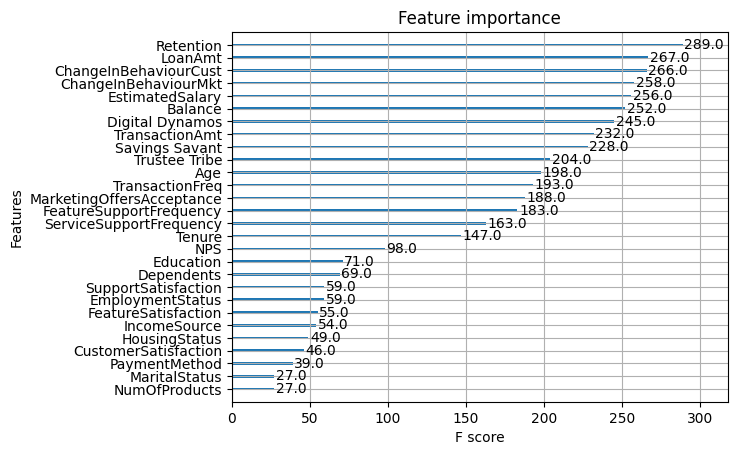

In [133]:
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

## Random Forest

In [ ]:
rf_model = RandomForestClassifier()

In [26]:
rf_param_dist = {
    'n_estimators': [100],
    'criterion': ['gini'],
    'max_depth': [None] + list(range(5, 11, 5)),
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 10]
}
#search = BayesSearchCV(
    #estimator=rf_model,
    #search_spaces=rf_param_dist,
    #n_iter=50,
    #cv=5
#)
#search = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

# Perform optimization
#search.fit(X_train, y_train)

#print("Best parameters found: ", search.best_params_)

# Evaluate the best model on the test set
#best_model = search.best_estimator_
#rf_predictions = best_model.predict(X_test)
#test_score = best_model.score(X_test, y_test)
#print("Test score of the best model: ", test_score)

In [27]:
rf_models = []
rf_results = []

for i in range(4):
    rf_model = RandomForestClassifier()
    search_rf = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=5, scoring='f1_weighted', cv=5, random_state=42)

    search_rf.fit(train_data_encoded[input_features], y_train_all[i])

    best_model_rf = search_rf.best_estimator_
    #best_model_rf = rf_model.fit(train_data_encoded[input_features], y_train_all[i])
    rf_models.append(best_model_rf)
    
    test_score_rf = best_model_rf.score(test_data_encoded[input_features], y_test_all[i])
    rf_results.append(test_score_rf)
    print("done yeay")

done yeay
done yeay
done yeay
done yeay


In [28]:
rf_results

[0.9999697033962492, 1.0, 0.9998182203774957, 0.9999697033962492]

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                  min_samples_leaf=1, 
                                  min_samples_split=2, random_state=42)

In [ ]:
best_model_rf = rf_model.fit(X_train, y_train_all[i])

In [ ]:
rf_models.append(best_model_rf)

In [ ]:
xgb_models

## Send Code to The Next Person

In [ ]:
lr_models

In [195]:
lr_model_dicts = []
for model in lr_models:
    model_dict = {
        "C": model.C,
        "penalty": model.penalty,
        "solver": model.solver
        # Add more attributes as needed
    }
    lr_model_dicts.append(model_dict)

rf_model_dicts = []
for model in rf_models:
    model_dict = {
        'n_estimators': model.n_estimators,
        'criterion': model.criterion,
        'max_depth': model.max_depth,
        'min_samples_leaf': model.min_samples_leaf,
        #'max_features': model.max_features,
        'min_samples_split': model.min_samples_split
    }
    rf_model_dicts.append(model_dict)

xgb_model_dicts = []
for model in xgb_models:
    model_dict = {
        'booster': model.booster,  
        'learning_rate': model.learning_rate,  
        'n_estimators': model.n_estimators,  
        'objective': model.objective,  
        #'objective': 'binary:logistic',
        'eval_metric': model.eval_metric,  
        'max_depth': model.max_depth,  
        'min_child_weight': model.min_child_weight,  
        'gamma': model.gamma,  
        'subsample': model.subsample,  
        'colsample_bytree': model.colsample_bytree,  
        'lambda': getattr(model, 'lambda', None),  # Access lambda attribute using getattr()
        'alpha': getattr(model, 'alpha', None),
        'num_class': 2
    }
    xgb_model_dicts.append(model_dict)

In [196]:
models = [lr_model_dicts, xgb_model_dicts, rf_model_dicts]

In [197]:
models

[[{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'},
  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}],
 [{'booster': 'gbtree',
   'learning_rate': 0.05,
   'n_estimators': 100,
   'objective': 'multi:softmax',
   'eval_metric': 'logloss',
   'max_depth': 3,
   'min_child_weight': 1,
   'gamma': 0,
   'subsample': 1.0,
   'colsample_bytree': 1.0,
   'lambda': None,
   'alpha': None,
   'num_class': 2},
  {'booster': 'gbtree',
   'learning_rate': 0.05,
   'n_estimators': 100,
   'objective': 'multi:softmax',
   'eval_metric': 'logloss',
   'max_depth': 3,
   'min_child_weight': 1,
   'gamma': 0,
   'subsample': 1.0,
   'colsample_bytree': 1.0,
   'lambda': None,
   'alpha': None,
   'num_class': 2},
  {'booster': 'gbtree',
   'learning_rate': 0.05,
   'n_estimators': 100,
   'objective': 'multi:softmax',
   'eval_metric': 'logloss',
   'max_depth': 3,
   'min_child_weight': 1,
 

In [198]:
models = [lr_model_dicts, xgb_model_dicts, rf_model_dicts]
#models = [lr_models, xgb_models, rf_models]

# Convert the list to JSON
json_data = json.dumps(models, indent=4)

# Write JSON data to a file
with open("Models.json", "w") as json_file:
    json_file.write(json_data)

In [136]:


# Convert the list to JSON
json_data = json.dumps(features_dropped)

# Write JSON data to a file
with open("FeatureDropped.json", "w") as json_file:
    json_file.write(json_data)